In [1]:
import cvxpy as cp
import scipy as sc
import numpy as np
import numpy.random as npr
import torch
from sklearn import datasets
import pandas as pd
import lropt
import sys
sys.path.append('..')
from utils import plot_tradeoff,plot_iters, plot_contours, plot_contours_line
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings("ignore")
plt.rcParams.update({
    "text.usetex":True,
    
    "font.size":24,
    "font.family": "serif"
})

### generate data

In [2]:
# Formulate constants
n = 2
N = 600
k_init = np.array([4.,5.])

def gen_demand_cor(N,seed,x1, x2):
    np.random.seed(seed)
    sig = np.eye(2)
    mu = np.array((6,7))
    points_list = []
    for i in range(N):
        mu_shift = -0.4*x1 - 0.1*x2
        newpoint = np.random.multivariate_normal(mu+mu_shift,sig)
        points_list.append(newpoint)
    return np.vstack(points_list)

In [3]:
s = 1
# in order for scenario to make sense, generate only 20 contexts
np.random.seed(s)
num_context = 20
num_reps = int(N/num_context)
init_k_data = np.maximum(0.5,k_init + np.random.normal(0,3,(num_context,n)))
init_p_data = init_k_data + np.maximum(0,np.random.normal(0,3,(num_context,n)))
p_data = np.repeat(init_p_data,num_reps,axis=0)
k_data = np.repeat(init_k_data,num_reps,axis=0)

# uncertain data depends on the contexts
init_data = [gen_demand_cor(num_reps,seed=5,x1=init_p_data[i],x2=init_k_data[i]) for i in range(num_context)] 
data = np.vstack(init_data)
test_p = 0.5

# split dataset
test_indices = np.random.choice(num_reps,int(test_p*num_reps), replace=False)
train_indices = [i for i in range(num_reps) if i not in test_indices]
train = np.array([init_data[j][i] for i in train_indices for j in range(num_context)])
test = np.array([init_data[j][i] for i in test_indices for j in range(num_context)])

def gen_weights_bias(k_data,p_data, data):
    stacked_context = np.hstack([p_data,k_data,np.ones((N,1))])
    mults_1 = np.linalg.lstsq(stacked_context,data[:,0])[0]
    mults_2 = np.linalg.lstsq(stacked_context,data[:,1])[0]
    mults_mean = np.vstack([mults_1, mults_2])
    mults_mean_weight = mults_mean[:,:-1]
    mults_mean_bias = mults_mean[:,-1]
    return mults_mean_weight, mults_mean_bias
mults_mean_weight, mults_mean_bias = gen_weights_bias(k_data,p_data, data)


### create lropt problem

In [4]:
# Formulate uncertainty set
u = lropt.UncertainParameter(n,
                        uncertainty_set=lropt.Ellipsoidal(
                                                    data=data))
# Formulate the Robust Problem
x_r = cp.Variable(n)
t = cp.Variable()
k = lropt.ContextParameter(2, data=k_data)
p = lropt.ContextParameter(2, data=p_data)
p_x = cp.Variable(n)
objective = cp.Minimize(t)
constraints = [lropt.max_of_uncertain([-p[0]*x_r[0] - p[1]*x_r[1],-p[0]*x_r[0] - p_x[1]*u[1], -p_x[0]*u[0] - p[1]*x_r[1], -p_x[0]*u[0]- p_x[1]*u[1]]) + k@x_r <= t]
constraints += [p_x == p]
constraints += [x_r >= 0]

eval_exp = k@x_r + cp.maximum(-p[0]*x_r[0] - p[1]*x_r[1],-p[0]*x_r[0] - p[1]*u[1], -p[0]*u[0] - p[1]*x_r[1], -p[0]*u[0]- p[1]*u[1]) 

prob = lropt.RobustProblem(objective, constraints,eval_exp = eval_exp)

### train lropt problem

In [5]:
num_iters = 500
initn = sc.linalg.sqrtm(np.cov(train.T))
init_bvaln = np.mean(train, axis=0)

# initialize linear weights and bias
init_bias = np.hstack([initn.flatten(),mults_mean_bias])
init_weight = np.vstack([np.zeros((4,4)),mults_mean_weight])

# Train A and b
from lropt import Trainer
trainer = Trainer(prob)
trainer_settings = lropt.TrainerSettings()

trainer_settings.lr=0.0001
trainer_settings.num_iter=num_iters  # number of training iterations 
trainer_settings.optimizer="SGD"
trainer_settings.seed=5
trainer_settings.init_A=initn
trainer_settings.init_b=init_bvaln
trainer_settings.init_lam=0.5
trainer_settings.init_mu=0.5
trainer_settings.mu_multiplier=1.001
trainer_settings.test_percentage = test_p
trainer_settings.save_history = True
trainer_settings.lr_step_size = 50  # scheduler - every 50 steps, multiply by lr_gamma
trainer_settings.lr_gamma = 0.5
trainer_settings.random_init = False  # if true, initializes at random sets
trainer_settings.num_random_init = 5
trainer_settings.parallel = True
trainer_settings.position = False
trainer_settings.eta=0.3
trainer_settings.contextual = True
trainer_settings.init_weight = init_weight  # initialization with ltsq pred
trainer_settings.init_bias = init_bias
result = trainer.train(trainer_settings=trainer_settings)
df = result.df
result.df.to_csv('linear_training.csv')
result.df_test.to_csv('linear_testing.csv')
A_fin = result.A
b_fin = result.b

/Users/irina.wang/Desktop/Princeton/Project2/lropt/lropt/train/trainer.py:161: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_0 = [torch.tensor(x, dtype=settings.DTYPE) for x in x_0]
/Users/irina.wang/anaconda3/envs/lropt_t1/lib/python3.11/site-packages/threadpoolctl.py:1214: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/Users/irina.wang/anaconda3/envs/lropt_t1/lib/python3.11/site-packages/cvxtorch/utils/torch_utils.py:20: Us

iteration 0, valid -4.0970e+00, vio 1.5000e-02


/Users/irina.wang/Desktop/Princeton/Project2/lropt/lropt/train/trainer.py:161: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_0 = [torch.tensor(x, dtype=settings.DTYPE) for x in x_0]
/Users/irina.wang/anaconda3/envs/lropt_t1/lib/python3.11/site-packages/threadpoolctl.py:1214: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/Users/irina.wang/Desktop/Princeton/Project2/lropt/lropt/train/trainer.py:161: UserWarning: To copy constru

iteration 10, valid -5.8020e+00, vio 2.3160e-01


/Users/irina.wang/Desktop/Princeton/Project2/lropt/lropt/train/trainer.py:161: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_0 = [torch.tensor(x, dtype=settings.DTYPE) for x in x_0]
/Users/irina.wang/anaconda3/envs/lropt_t1/lib/python3.11/site-packages/threadpoolctl.py:1214: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/Users/irina.wang/Desktop/Princeton/Project2/lropt/lropt/train/trainer.py:161: UserWarning: To copy constru

iteration 20, valid -4.2437e+00, vio 3.2531e-01


/Users/irina.wang/Desktop/Princeton/Project2/lropt/lropt/train/trainer.py:161: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_0 = [torch.tensor(x, dtype=settings.DTYPE) for x in x_0]
/Users/irina.wang/anaconda3/envs/lropt_t1/lib/python3.11/site-packages/threadpoolctl.py:1214: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/Users/irina.wang/Desktop/Princeton/Project2/lropt/lropt/train/trainer.py:161: UserWarning: To copy constru

iteration 30, valid -5.9205e+00, vio 1.4949e+00


/Users/irina.wang/Desktop/Princeton/Project2/lropt/lropt/train/trainer.py:161: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_0 = [torch.tensor(x, dtype=settings.DTYPE) for x in x_0]
/Users/irina.wang/anaconda3/envs/lropt_t1/lib/python3.11/site-packages/threadpoolctl.py:1214: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/Users/irina.wang/Desktop/Princeton/Project2/lropt/lropt/train/trainer.py:161: UserWarning: To copy constru

iteration 40, valid -6.4580e+00, vio 1.0797e+00


/Users/irina.wang/Desktop/Princeton/Project2/lropt/lropt/train/trainer.py:161: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_0 = [torch.tensor(x, dtype=settings.DTYPE) for x in x_0]
/Users/irina.wang/anaconda3/envs/lropt_t1/lib/python3.11/site-packages/threadpoolctl.py:1214: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/Users/irina.wang/Desktop/Princeton/Project2/lropt/lropt/train/trainer.py:161: UserWarning: To copy constru

iteration 50, valid -5.5093e+00, vio 1.0277e-01


/Users/irina.wang/Desktop/Princeton/Project2/lropt/lropt/train/trainer.py:161: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_0 = [torch.tensor(x, dtype=settings.DTYPE) for x in x_0]
/Users/irina.wang/anaconda3/envs/lropt_t1/lib/python3.11/site-packages/threadpoolctl.py:1214: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/Users/irina.wang/Desktop/Princeton/Project2/lropt/lropt/train/trainer.py:161: UserWarning: To copy constru

iteration 60, valid -7.8400e+00, vio 2.6365e-01


/Users/irina.wang/Desktop/Princeton/Project2/lropt/lropt/train/trainer.py:161: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_0 = [torch.tensor(x, dtype=settings.DTYPE) for x in x_0]
/Users/irina.wang/anaconda3/envs/lropt_t1/lib/python3.11/site-packages/threadpoolctl.py:1214: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/Users/irina.wang/Desktop/Princeton/Project2/lropt/lropt/train/trainer.py:161: UserWarning: To copy constru

iteration 70, valid -7.6813e+00, vio 8.4725e-01


/Users/irina.wang/Desktop/Princeton/Project2/lropt/lropt/train/trainer.py:161: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_0 = [torch.tensor(x, dtype=settings.DTYPE) for x in x_0]
/Users/irina.wang/anaconda3/envs/lropt_t1/lib/python3.11/site-packages/threadpoolctl.py:1214: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/Users/irina.wang/Desktop/Princeton/Project2/lropt/lropt/train/trainer.py:161: UserWarning: To copy constru

iteration 80, valid -6.5322e+00, vio 3.2234e-01


/Users/irina.wang/Desktop/Princeton/Project2/lropt/lropt/train/trainer.py:161: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_0 = [torch.tensor(x, dtype=settings.DTYPE) for x in x_0]
/Users/irina.wang/anaconda3/envs/lropt_t1/lib/python3.11/site-packages/threadpoolctl.py:1214: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/Users/irina.wang/Desktop/Princeton/Project2/lropt/lropt/train/trainer.py:161: UserWarning: To copy constru

iteration 90, valid -3.7647e+00, vio 2.0950e-01


/Users/irina.wang/Desktop/Princeton/Project2/lropt/lropt/train/trainer.py:161: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_0 = [torch.tensor(x, dtype=settings.DTYPE) for x in x_0]
/Users/irina.wang/anaconda3/envs/lropt_t1/lib/python3.11/site-packages/threadpoolctl.py:1214: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/Users/irina.wang/Desktop/Princeton/Project2/lropt/lropt/train/trainer.py:161: UserWarning: To copy constru

iteration 100, valid -6.0159e+00, vio 1.5496e+00


/Users/irina.wang/Desktop/Princeton/Project2/lropt/lropt/train/trainer.py:161: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_0 = [torch.tensor(x, dtype=settings.DTYPE) for x in x_0]
/Users/irina.wang/anaconda3/envs/lropt_t1/lib/python3.11/site-packages/threadpoolctl.py:1214: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/Users/irina.wang/Desktop/Princeton/Project2/lropt/lropt/train/trainer.py:161: UserWarning: To copy constru

iteration 110, valid -4.9947e+00, vio 1.4399e+00


/Users/irina.wang/Desktop/Princeton/Project2/lropt/lropt/train/trainer.py:161: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_0 = [torch.tensor(x, dtype=settings.DTYPE) for x in x_0]
/Users/irina.wang/anaconda3/envs/lropt_t1/lib/python3.11/site-packages/threadpoolctl.py:1214: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/Users/irina.wang/Desktop/Princeton/Project2/lropt/lropt/train/trainer.py:161: UserWarning: To copy constru

iteration 120, valid -6.9890e+00, vio 3.9700e-01


/Users/irina.wang/Desktop/Princeton/Project2/lropt/lropt/train/trainer.py:161: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_0 = [torch.tensor(x, dtype=settings.DTYPE) for x in x_0]
/Users/irina.wang/anaconda3/envs/lropt_t1/lib/python3.11/site-packages/threadpoolctl.py:1214: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/Users/irina.wang/Desktop/Princeton/Project2/lropt/lropt/train/trainer.py:161: UserWarning: To copy constru

iteration 130, valid -4.4722e+00, vio 1.1971e+00


/Users/irina.wang/Desktop/Princeton/Project2/lropt/lropt/train/trainer.py:161: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_0 = [torch.tensor(x, dtype=settings.DTYPE) for x in x_0]
/Users/irina.wang/anaconda3/envs/lropt_t1/lib/python3.11/site-packages/threadpoolctl.py:1214: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/Users/irina.wang/Desktop/Princeton/Project2/lropt/lropt/train/trainer.py:161: UserWarning: To copy constru

iteration 140, valid -7.3920e+00, vio 2.3752e-01


/Users/irina.wang/Desktop/Princeton/Project2/lropt/lropt/train/trainer.py:161: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_0 = [torch.tensor(x, dtype=settings.DTYPE) for x in x_0]
/Users/irina.wang/anaconda3/envs/lropt_t1/lib/python3.11/site-packages/threadpoolctl.py:1214: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/Users/irina.wang/Desktop/Princeton/Project2/lropt/lropt/train/trainer.py:161: UserWarning: To copy constru

iteration 150, valid -5.5146e+00, vio 1.0806e-01


/Users/irina.wang/Desktop/Princeton/Project2/lropt/lropt/train/trainer.py:161: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_0 = [torch.tensor(x, dtype=settings.DTYPE) for x in x_0]
/Users/irina.wang/anaconda3/envs/lropt_t1/lib/python3.11/site-packages/threadpoolctl.py:1214: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/Users/irina.wang/Desktop/Princeton/Project2/lropt/lropt/train/trainer.py:161: UserWarning: To copy constru

iteration 160, valid -5.9060e+00, vio 1.1131e-01


/Users/irina.wang/Desktop/Princeton/Project2/lropt/lropt/train/trainer.py:161: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_0 = [torch.tensor(x, dtype=settings.DTYPE) for x in x_0]
/Users/irina.wang/anaconda3/envs/lropt_t1/lib/python3.11/site-packages/threadpoolctl.py:1214: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/Users/irina.wang/Desktop/Princeton/Project2/lropt/lropt/train/trainer.py:161: UserWarning: To copy constru

iteration 170, valid -7.7711e+00, vio 4.9810e-01


/Users/irina.wang/Desktop/Princeton/Project2/lropt/lropt/train/trainer.py:161: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_0 = [torch.tensor(x, dtype=settings.DTYPE) for x in x_0]
/Users/irina.wang/anaconda3/envs/lropt_t1/lib/python3.11/site-packages/threadpoolctl.py:1214: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/Users/irina.wang/Desktop/Princeton/Project2/lropt/lropt/train/trainer.py:161: UserWarning: To copy constru

iteration 180, valid -7.5093e+00, vio 3.0795e-01


/Users/irina.wang/Desktop/Princeton/Project2/lropt/lropt/train/trainer.py:161: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_0 = [torch.tensor(x, dtype=settings.DTYPE) for x in x_0]
/Users/irina.wang/anaconda3/envs/lropt_t1/lib/python3.11/site-packages/threadpoolctl.py:1214: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/Users/irina.wang/Desktop/Princeton/Project2/lropt/lropt/train/trainer.py:161: UserWarning: To copy constru

iteration 190, valid -6.5851e+00, vio 2.1853e-01


/Users/irina.wang/Desktop/Princeton/Project2/lropt/lropt/train/trainer.py:161: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_0 = [torch.tensor(x, dtype=settings.DTYPE) for x in x_0]
/Users/irina.wang/anaconda3/envs/lropt_t1/lib/python3.11/site-packages/threadpoolctl.py:1214: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/Users/irina.wang/Desktop/Princeton/Project2/lropt/lropt/train/trainer.py:161: UserWarning: To copy constru

iteration 200, valid -7.9235e+00, vio 7.2905e-01


/Users/irina.wang/Desktop/Princeton/Project2/lropt/lropt/train/trainer.py:161: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_0 = [torch.tensor(x, dtype=settings.DTYPE) for x in x_0]
/Users/irina.wang/anaconda3/envs/lropt_t1/lib/python3.11/site-packages/threadpoolctl.py:1214: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/Users/irina.wang/Desktop/Princeton/Project2/lropt/lropt/train/trainer.py:161: UserWarning: To copy constru

iteration 210, valid -5.8699e+00, vio 5.8292e-01


/Users/irina.wang/Desktop/Princeton/Project2/lropt/lropt/train/trainer.py:161: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_0 = [torch.tensor(x, dtype=settings.DTYPE) for x in x_0]
/Users/irina.wang/anaconda3/envs/lropt_t1/lib/python3.11/site-packages/threadpoolctl.py:1214: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/Users/irina.wang/Desktop/Princeton/Project2/lropt/lropt/train/trainer.py:161: UserWarning: To copy constru

iteration 220, valid -7.7320e+00, vio 2.9576e-01


/Users/irina.wang/Desktop/Princeton/Project2/lropt/lropt/train/trainer.py:161: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_0 = [torch.tensor(x, dtype=settings.DTYPE) for x in x_0]
/Users/irina.wang/anaconda3/envs/lropt_t1/lib/python3.11/site-packages/threadpoolctl.py:1214: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/Users/irina.wang/Desktop/Princeton/Project2/lropt/lropt/train/trainer.py:161: UserWarning: To copy constru

iteration 230, valid -7.9507e+00, vio 9.2684e-01


/Users/irina.wang/Desktop/Princeton/Project2/lropt/lropt/train/trainer.py:161: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_0 = [torch.tensor(x, dtype=settings.DTYPE) for x in x_0]
/Users/irina.wang/anaconda3/envs/lropt_t1/lib/python3.11/site-packages/threadpoolctl.py:1214: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/Users/irina.wang/Desktop/Princeton/Project2/lropt/lropt/train/trainer.py:161: UserWarning: To copy constru

iteration 240, valid -6.7598e+00, vio 1.8569e+00


/Users/irina.wang/Desktop/Princeton/Project2/lropt/lropt/train/trainer.py:161: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_0 = [torch.tensor(x, dtype=settings.DTYPE) for x in x_0]
/Users/irina.wang/anaconda3/envs/lropt_t1/lib/python3.11/site-packages/threadpoolctl.py:1214: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/Users/irina.wang/Desktop/Princeton/Project2/lropt/lropt/train/trainer.py:161: UserWarning: To copy constru

iteration 250, valid -4.9930e+00, vio 9.3047e-01


/Users/irina.wang/Desktop/Princeton/Project2/lropt/lropt/train/trainer.py:161: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_0 = [torch.tensor(x, dtype=settings.DTYPE) for x in x_0]
/Users/irina.wang/anaconda3/envs/lropt_t1/lib/python3.11/site-packages/threadpoolctl.py:1214: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/Users/irina.wang/Desktop/Princeton/Project2/lropt/lropt/train/trainer.py:161: UserWarning: To copy constru

iteration 260, valid -5.8916e+00, vio 1.8970e-01


/Users/irina.wang/Desktop/Princeton/Project2/lropt/lropt/train/trainer.py:161: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_0 = [torch.tensor(x, dtype=settings.DTYPE) for x in x_0]
/Users/irina.wang/anaconda3/envs/lropt_t1/lib/python3.11/site-packages/threadpoolctl.py:1214: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/Users/irina.wang/Desktop/Princeton/Project2/lropt/lropt/train/trainer.py:161: UserWarning: To copy constru

iteration 270, valid -6.8609e+00, vio 8.0057e-01


/Users/irina.wang/Desktop/Princeton/Project2/lropt/lropt/train/trainer.py:161: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_0 = [torch.tensor(x, dtype=settings.DTYPE) for x in x_0]
/Users/irina.wang/anaconda3/envs/lropt_t1/lib/python3.11/site-packages/threadpoolctl.py:1214: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/Users/irina.wang/Desktop/Princeton/Project2/lropt/lropt/train/trainer.py:161: UserWarning: To copy constru

iteration 280, valid -4.2589e+00, vio 1.2248e-01


/Users/irina.wang/Desktop/Princeton/Project2/lropt/lropt/train/trainer.py:161: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_0 = [torch.tensor(x, dtype=settings.DTYPE) for x in x_0]
/Users/irina.wang/anaconda3/envs/lropt_t1/lib/python3.11/site-packages/threadpoolctl.py:1214: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/Users/irina.wang/Desktop/Princeton/Project2/lropt/lropt/train/trainer.py:161: UserWarning: To copy constru

iteration 290, valid -4.8733e+00, vio 7.2320e-01


/Users/irina.wang/Desktop/Princeton/Project2/lropt/lropt/train/trainer.py:161: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_0 = [torch.tensor(x, dtype=settings.DTYPE) for x in x_0]
/Users/irina.wang/anaconda3/envs/lropt_t1/lib/python3.11/site-packages/threadpoolctl.py:1214: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/Users/irina.wang/Desktop/Princeton/Project2/lropt/lropt/train/trainer.py:161: UserWarning: To copy constru

iteration 300, valid -4.5814e+00, vio 5.9840e-01


/Users/irina.wang/Desktop/Princeton/Project2/lropt/lropt/train/trainer.py:161: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_0 = [torch.tensor(x, dtype=settings.DTYPE) for x in x_0]
/Users/irina.wang/anaconda3/envs/lropt_t1/lib/python3.11/site-packages/threadpoolctl.py:1214: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/Users/irina.wang/Desktop/Princeton/Project2/lropt/lropt/train/trainer.py:161: UserWarning: To copy constru

iteration 310, valid -7.5875e+00, vio 1.5826e+00


/Users/irina.wang/Desktop/Princeton/Project2/lropt/lropt/train/trainer.py:161: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_0 = [torch.tensor(x, dtype=settings.DTYPE) for x in x_0]
/Users/irina.wang/anaconda3/envs/lropt_t1/lib/python3.11/site-packages/threadpoolctl.py:1214: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/Users/irina.wang/Desktop/Princeton/Project2/lropt/lropt/train/trainer.py:161: UserWarning: To copy constru

iteration 320, valid -4.7356e+00, vio 1.6024e+00


/Users/irina.wang/Desktop/Princeton/Project2/lropt/lropt/train/trainer.py:161: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_0 = [torch.tensor(x, dtype=settings.DTYPE) for x in x_0]
/Users/irina.wang/anaconda3/envs/lropt_t1/lib/python3.11/site-packages/threadpoolctl.py:1214: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/Users/irina.wang/Desktop/Princeton/Project2/lropt/lropt/train/trainer.py:161: UserWarning: To copy constru

iteration 330, valid -8.5244e+00, vio 1.9358e-01


/Users/irina.wang/Desktop/Princeton/Project2/lropt/lropt/train/trainer.py:161: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_0 = [torch.tensor(x, dtype=settings.DTYPE) for x in x_0]
/Users/irina.wang/anaconda3/envs/lropt_t1/lib/python3.11/site-packages/threadpoolctl.py:1214: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/Users/irina.wang/Desktop/Princeton/Project2/lropt/lropt/train/trainer.py:161: UserWarning: To copy constru

iteration 340, valid -5.4673e+00, vio 4.2185e-01


/Users/irina.wang/Desktop/Princeton/Project2/lropt/lropt/train/trainer.py:161: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_0 = [torch.tensor(x, dtype=settings.DTYPE) for x in x_0]
/Users/irina.wang/anaconda3/envs/lropt_t1/lib/python3.11/site-packages/threadpoolctl.py:1214: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/Users/irina.wang/Desktop/Princeton/Project2/lropt/lropt/train/trainer.py:161: UserWarning: To copy constru

iteration 350, valid -6.1419e+00, vio 1.3397e+00


/Users/irina.wang/Desktop/Princeton/Project2/lropt/lropt/train/trainer.py:161: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_0 = [torch.tensor(x, dtype=settings.DTYPE) for x in x_0]
/Users/irina.wang/anaconda3/envs/lropt_t1/lib/python3.11/site-packages/threadpoolctl.py:1214: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/Users/irina.wang/Desktop/Princeton/Project2/lropt/lropt/train/trainer.py:161: UserWarning: To copy constru

iteration 360, valid -6.8033e+00, vio 1.4220e+00


/Users/irina.wang/Desktop/Princeton/Project2/lropt/lropt/train/trainer.py:161: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_0 = [torch.tensor(x, dtype=settings.DTYPE) for x in x_0]
/Users/irina.wang/anaconda3/envs/lropt_t1/lib/python3.11/site-packages/threadpoolctl.py:1214: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/Users/irina.wang/Desktop/Princeton/Project2/lropt/lropt/train/trainer.py:161: UserWarning: To copy constru

iteration 370, valid -4.6714e+00, vio 6.9865e-01


/Users/irina.wang/Desktop/Princeton/Project2/lropt/lropt/train/trainer.py:161: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_0 = [torch.tensor(x, dtype=settings.DTYPE) for x in x_0]
/Users/irina.wang/anaconda3/envs/lropt_t1/lib/python3.11/site-packages/threadpoolctl.py:1214: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/Users/irina.wang/Desktop/Princeton/Project2/lropt/lropt/train/trainer.py:161: UserWarning: To copy constru

iteration 380, valid -4.8561e+00, vio 1.5599e+00


/Users/irina.wang/Desktop/Princeton/Project2/lropt/lropt/train/trainer.py:161: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_0 = [torch.tensor(x, dtype=settings.DTYPE) for x in x_0]
/Users/irina.wang/anaconda3/envs/lropt_t1/lib/python3.11/site-packages/threadpoolctl.py:1214: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/Users/irina.wang/Desktop/Princeton/Project2/lropt/lropt/train/trainer.py:161: UserWarning: To copy constru

iteration 390, valid -6.2065e+00, vio 1.1959e+00


/Users/irina.wang/Desktop/Princeton/Project2/lropt/lropt/train/trainer.py:161: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_0 = [torch.tensor(x, dtype=settings.DTYPE) for x in x_0]
/Users/irina.wang/anaconda3/envs/lropt_t1/lib/python3.11/site-packages/threadpoolctl.py:1214: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/Users/irina.wang/Desktop/Princeton/Project2/lropt/lropt/train/trainer.py:161: UserWarning: To copy constru

iteration 400, valid -6.8075e+00, vio 7.4729e-01


/Users/irina.wang/Desktop/Princeton/Project2/lropt/lropt/train/trainer.py:161: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_0 = [torch.tensor(x, dtype=settings.DTYPE) for x in x_0]
/Users/irina.wang/anaconda3/envs/lropt_t1/lib/python3.11/site-packages/threadpoolctl.py:1214: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/Users/irina.wang/Desktop/Princeton/Project2/lropt/lropt/train/trainer.py:161: UserWarning: To copy constru

iteration 410, valid -7.0126e+00, vio 1.0892e+00


/Users/irina.wang/Desktop/Princeton/Project2/lropt/lropt/train/trainer.py:161: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_0 = [torch.tensor(x, dtype=settings.DTYPE) for x in x_0]
/Users/irina.wang/anaconda3/envs/lropt_t1/lib/python3.11/site-packages/threadpoolctl.py:1214: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/Users/irina.wang/Desktop/Princeton/Project2/lropt/lropt/train/trainer.py:161: UserWarning: To copy constru

iteration 420, valid -8.3948e+00, vio 3.8210e-01


/Users/irina.wang/Desktop/Princeton/Project2/lropt/lropt/train/trainer.py:161: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_0 = [torch.tensor(x, dtype=settings.DTYPE) for x in x_0]
/Users/irina.wang/anaconda3/envs/lropt_t1/lib/python3.11/site-packages/threadpoolctl.py:1214: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/Users/irina.wang/Desktop/Princeton/Project2/lropt/lropt/train/trainer.py:161: UserWarning: To copy constru

iteration 430, valid -6.1796e+00, vio 1.1515e+00


/Users/irina.wang/Desktop/Princeton/Project2/lropt/lropt/train/trainer.py:161: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_0 = [torch.tensor(x, dtype=settings.DTYPE) for x in x_0]
/Users/irina.wang/anaconda3/envs/lropt_t1/lib/python3.11/site-packages/threadpoolctl.py:1214: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/Users/irina.wang/Desktop/Princeton/Project2/lropt/lropt/train/trainer.py:161: UserWarning: To copy constru

iteration 440, valid -6.1800e+00, vio 6.1686e-01


/Users/irina.wang/Desktop/Princeton/Project2/lropt/lropt/train/trainer.py:161: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_0 = [torch.tensor(x, dtype=settings.DTYPE) for x in x_0]
/Users/irina.wang/anaconda3/envs/lropt_t1/lib/python3.11/site-packages/threadpoolctl.py:1214: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/Users/irina.wang/Desktop/Princeton/Project2/lropt/lropt/train/trainer.py:161: UserWarning: To copy constru

iteration 450, valid -6.7316e+00, vio 2.7902e-01


/Users/irina.wang/Desktop/Princeton/Project2/lropt/lropt/train/trainer.py:161: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_0 = [torch.tensor(x, dtype=settings.DTYPE) for x in x_0]
/Users/irina.wang/anaconda3/envs/lropt_t1/lib/python3.11/site-packages/threadpoolctl.py:1214: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/Users/irina.wang/Desktop/Princeton/Project2/lropt/lropt/train/trainer.py:161: UserWarning: To copy constru

iteration 460, valid -5.6267e+00, vio 6.0835e-01


/Users/irina.wang/Desktop/Princeton/Project2/lropt/lropt/train/trainer.py:161: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_0 = [torch.tensor(x, dtype=settings.DTYPE) for x in x_0]
/Users/irina.wang/anaconda3/envs/lropt_t1/lib/python3.11/site-packages/threadpoolctl.py:1214: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/Users/irina.wang/Desktop/Princeton/Project2/lropt/lropt/train/trainer.py:161: UserWarning: To copy constru

iteration 470, valid -4.9864e+00, vio 4.5384e-01


/Users/irina.wang/Desktop/Princeton/Project2/lropt/lropt/train/trainer.py:161: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_0 = [torch.tensor(x, dtype=settings.DTYPE) for x in x_0]
/Users/irina.wang/anaconda3/envs/lropt_t1/lib/python3.11/site-packages/threadpoolctl.py:1214: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/Users/irina.wang/Desktop/Princeton/Project2/lropt/lropt/train/trainer.py:161: UserWarning: To copy constru

iteration 480, valid -5.9444e+00, vio 4.6439e-01


/Users/irina.wang/Desktop/Princeton/Project2/lropt/lropt/train/trainer.py:161: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_0 = [torch.tensor(x, dtype=settings.DTYPE) for x in x_0]
/Users/irina.wang/anaconda3/envs/lropt_t1/lib/python3.11/site-packages/threadpoolctl.py:1214: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/Users/irina.wang/Desktop/Princeton/Project2/lropt/lropt/train/trainer.py:161: UserWarning: To copy constru

iteration 490, valid -6.2015e+00, vio 6.6816e-01


/Users/irina.wang/Desktop/Princeton/Project2/lropt/lropt/train/trainer.py:161: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_0 = [torch.tensor(x, dtype=settings.DTYPE) for x in x_0]
/Users/irina.wang/anaconda3/envs/lropt_t1/lib/python3.11/site-packages/threadpoolctl.py:1214: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/Users/irina.wang/Desktop/Princeton/Project2/lropt/lropt/train/trainer.py:161: UserWarning: To copy constru

In [6]:
# no training (steps = 1, look at initalized set)
trainer_settings.num_iter = 1 
result2 = trainer.train(trainer_settings=trainer_settings)
df2 = result.df
A_fin2 = result.A
b_fin2 = result.b

/Users/irina.wang/Desktop/Princeton/Project2/lropt/lropt/train/trainer.py:161: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_0 = [torch.tensor(x, dtype=settings.DTYPE) for x in x_0]
/Users/irina.wang/anaconda3/envs/lropt_t1/lib/python3.11/site-packages/threadpoolctl.py:1214: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/Users/irina.wang/anaconda3/envs/lropt_t1/lib/python3.11/site-packages/cvxtorch/utils/torch_utils.py:20: Us

iteration 0, valid -6.0510e+00, vio 1.5000e-02


In [7]:
# cov_pred initialization, untrained
trainer_settings.num_iter = 1
trainer_settings.covpred = True
result3 = trainer.train(trainer_settings=trainer_settings)
df3 = result3.df
A_fin3 = result3.A
b_fin3 = result3.b

eps_list = np.linspace(0.5, 2.5, 10)
# covpred untrained
result_grid4 = trainer.grid(rholst=eps_list,init_A=A_fin3, init_b=b_fin3, seed=s,init_alpha=0., test_percentage=test_p,quantiles = (0.3,0.7), contextual = True, covpred = True)
dfgrid4 = result_grid4.df
dfgrid4.to_csv('covpred_untrained_grid.csv')

/Users/irina.wang/Desktop/Princeton/Project2/lropt/lropt/train/cov_predict.py:32: RuntimeWarning: invalid value encountered in log
  f = -np.log(L[:, diag_rows, diag_cols]).sum() / T + \
/Users/irina.wang/Desktop/Princeton/Project2/lropt/lropt/train/trainer.py:161: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_0 = [torch.tensor(x, dtype=settings.DTYPE) for x in x_0]
/Users/irina.wang/anaconda3/envs/lropt_t1/lib/python3.11/site-packages/threadpoolctl.py:1214: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/thr

iteration 0, valid -4.3416e+00, vio 1.7707e+00


In [8]:
# cov_pred initialization, trained
trainer_settings.lr=0.00001
trainer_settings.num_iter = num_iters
trainer_settings.covpred = True
result4 = trainer.train(trainer_settings=trainer_settings)
df4 = result4.df
A_fin4 = result4.A
b_fin4 = result4.b
result4.df.to_csv('covpred_training.csv')
result4.df_test.to_csv('covpred_testing.csv')

/Users/irina.wang/Desktop/Princeton/Project2/lropt/lropt/train/cov_predict.py:32: RuntimeWarning: invalid value encountered in log
  f = -np.log(L[:, diag_rows, diag_cols]).sum() / T + \
/Users/irina.wang/Desktop/Princeton/Project2/lropt/lropt/train/trainer.py:161: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_0 = [torch.tensor(x, dtype=settings.DTYPE) for x in x_0]
/Users/irina.wang/anaconda3/envs/lropt_t1/lib/python3.11/site-packages/threadpoolctl.py:1214: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/thr

iteration 0, valid -3.6017e+00, vio 3.7168e+00


/Users/irina.wang/Desktop/Princeton/Project2/lropt/lropt/train/trainer.py:161: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_0 = [torch.tensor(x, dtype=settings.DTYPE) for x in x_0]
/Users/irina.wang/anaconda3/envs/lropt_t1/lib/python3.11/site-packages/threadpoolctl.py:1214: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/Users/irina.wang/Desktop/Princeton/Project2/lropt/lropt/train/trainer.py:161: UserWarning: To copy constru

iteration 10, valid -6.3768e-01, vio 1.4920e-02


/Users/irina.wang/Desktop/Princeton/Project2/lropt/lropt/train/trainer.py:161: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_0 = [torch.tensor(x, dtype=settings.DTYPE) for x in x_0]
/Users/irina.wang/anaconda3/envs/lropt_t1/lib/python3.11/site-packages/threadpoolctl.py:1214: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/Users/irina.wang/Desktop/Princeton/Project2/lropt/lropt/train/trainer.py:161: UserWarning: To copy constru

iteration 20, valid -7.7912e-01, vio 1.5140e-02


/Users/irina.wang/Desktop/Princeton/Project2/lropt/lropt/train/trainer.py:161: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_0 = [torch.tensor(x, dtype=settings.DTYPE) for x in x_0]
/Users/irina.wang/anaconda3/envs/lropt_t1/lib/python3.11/site-packages/threadpoolctl.py:1214: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/Users/irina.wang/Desktop/Princeton/Project2/lropt/lropt/train/trainer.py:161: UserWarning: To copy constru

iteration 30, valid -6.9047e-01, vio 1.5025e-02


/Users/irina.wang/Desktop/Princeton/Project2/lropt/lropt/train/trainer.py:161: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_0 = [torch.tensor(x, dtype=settings.DTYPE) for x in x_0]
/Users/irina.wang/anaconda3/envs/lropt_t1/lib/python3.11/site-packages/threadpoolctl.py:1214: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/Users/irina.wang/Desktop/Princeton/Project2/lropt/lropt/train/trainer.py:161: UserWarning: To copy constru

iteration 40, valid -1.0131e+00, vio 1.5022e-02


/Users/irina.wang/Desktop/Princeton/Project2/lropt/lropt/train/trainer.py:161: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_0 = [torch.tensor(x, dtype=settings.DTYPE) for x in x_0]
/Users/irina.wang/anaconda3/envs/lropt_t1/lib/python3.11/site-packages/threadpoolctl.py:1214: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/Users/irina.wang/Desktop/Princeton/Project2/lropt/lropt/train/trainer.py:161: UserWarning: To copy constru

iteration 50, valid -1.2025e+00, vio 1.5047e-02


/Users/irina.wang/Desktop/Princeton/Project2/lropt/lropt/train/trainer.py:161: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_0 = [torch.tensor(x, dtype=settings.DTYPE) for x in x_0]
/Users/irina.wang/anaconda3/envs/lropt_t1/lib/python3.11/site-packages/threadpoolctl.py:1214: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/Users/irina.wang/Desktop/Princeton/Project2/lropt/lropt/train/trainer.py:161: UserWarning: To copy constru

iteration 60, valid -1.1029e+00, vio 1.5003e-02


/Users/irina.wang/Desktop/Princeton/Project2/lropt/lropt/train/trainer.py:161: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_0 = [torch.tensor(x, dtype=settings.DTYPE) for x in x_0]
/Users/irina.wang/anaconda3/envs/lropt_t1/lib/python3.11/site-packages/threadpoolctl.py:1214: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/Users/irina.wang/Desktop/Princeton/Project2/lropt/lropt/train/trainer.py:161: UserWarning: To copy constru

iteration 70, valid -1.3128e+00, vio 2.7535e-01


/Users/irina.wang/Desktop/Princeton/Project2/lropt/lropt/train/trainer.py:161: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_0 = [torch.tensor(x, dtype=settings.DTYPE) for x in x_0]
/Users/irina.wang/anaconda3/envs/lropt_t1/lib/python3.11/site-packages/threadpoolctl.py:1214: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/Users/irina.wang/Desktop/Princeton/Project2/lropt/lropt/train/trainer.py:161: UserWarning: To copy constru

iteration 80, valid -1.0730e+00, vio 1.5032e-02


/Users/irina.wang/Desktop/Princeton/Project2/lropt/lropt/train/trainer.py:161: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_0 = [torch.tensor(x, dtype=settings.DTYPE) for x in x_0]
/Users/irina.wang/anaconda3/envs/lropt_t1/lib/python3.11/site-packages/threadpoolctl.py:1214: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/Users/irina.wang/Desktop/Princeton/Project2/lropt/lropt/train/trainer.py:161: UserWarning: To copy constru

iteration 90, valid -6.2186e-01, vio 1.5027e-02


/Users/irina.wang/Desktop/Princeton/Project2/lropt/lropt/train/trainer.py:161: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_0 = [torch.tensor(x, dtype=settings.DTYPE) for x in x_0]
/Users/irina.wang/anaconda3/envs/lropt_t1/lib/python3.11/site-packages/threadpoolctl.py:1214: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/Users/irina.wang/Desktop/Princeton/Project2/lropt/lropt/train/trainer.py:161: UserWarning: To copy constru

iteration 100, valid -7.9753e-01, vio 1.8474e-01


/Users/irina.wang/Desktop/Princeton/Project2/lropt/lropt/train/trainer.py:161: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_0 = [torch.tensor(x, dtype=settings.DTYPE) for x in x_0]
/Users/irina.wang/anaconda3/envs/lropt_t1/lib/python3.11/site-packages/threadpoolctl.py:1214: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/Users/irina.wang/Desktop/Princeton/Project2/lropt/lropt/train/trainer.py:161: UserWarning: To copy constru

iteration 110, valid -9.7426e-01, vio 2.7552e-01


/Users/irina.wang/Desktop/Princeton/Project2/lropt/lropt/train/trainer.py:161: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_0 = [torch.tensor(x, dtype=settings.DTYPE) for x in x_0]
/Users/irina.wang/anaconda3/envs/lropt_t1/lib/python3.11/site-packages/threadpoolctl.py:1214: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/Users/irina.wang/Desktop/Princeton/Project2/lropt/lropt/train/trainer.py:161: UserWarning: To copy constru

iteration 120, valid -1.1301e+00, vio 1.5004e-02


/Users/irina.wang/Desktop/Princeton/Project2/lropt/lropt/train/trainer.py:161: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_0 = [torch.tensor(x, dtype=settings.DTYPE) for x in x_0]
/Users/irina.wang/anaconda3/envs/lropt_t1/lib/python3.11/site-packages/threadpoolctl.py:1214: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/Users/irina.wang/Desktop/Princeton/Project2/lropt/lropt/train/trainer.py:161: UserWarning: To copy constru

iteration 130, valid -1.2801e+00, vio 1.5003e-02


/Users/irina.wang/Desktop/Princeton/Project2/lropt/lropt/train/trainer.py:161: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_0 = [torch.tensor(x, dtype=settings.DTYPE) for x in x_0]
/Users/irina.wang/anaconda3/envs/lropt_t1/lib/python3.11/site-packages/threadpoolctl.py:1214: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/Users/irina.wang/Desktop/Princeton/Project2/lropt/lropt/train/trainer.py:161: UserWarning: To copy constru

iteration 140, valid -8.9810e-01, vio 1.5002e-02


/Users/irina.wang/Desktop/Princeton/Project2/lropt/lropt/train/trainer.py:161: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_0 = [torch.tensor(x, dtype=settings.DTYPE) for x in x_0]
/Users/irina.wang/anaconda3/envs/lropt_t1/lib/python3.11/site-packages/threadpoolctl.py:1214: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/Users/irina.wang/Desktop/Princeton/Project2/lropt/lropt/train/trainer.py:161: UserWarning: To copy constru

iteration 150, valid -1.0204e+00, vio 2.5972e-01


/Users/irina.wang/Desktop/Princeton/Project2/lropt/lropt/train/trainer.py:161: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_0 = [torch.tensor(x, dtype=settings.DTYPE) for x in x_0]
/Users/irina.wang/anaconda3/envs/lropt_t1/lib/python3.11/site-packages/threadpoolctl.py:1214: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/Users/irina.wang/Desktop/Princeton/Project2/lropt/lropt/train/trainer.py:161: UserWarning: To copy constru

iteration 160, valid -1.1372e+00, vio 5.5155e-01


/Users/irina.wang/Desktop/Princeton/Project2/lropt/lropt/train/trainer.py:161: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_0 = [torch.tensor(x, dtype=settings.DTYPE) for x in x_0]
/Users/irina.wang/anaconda3/envs/lropt_t1/lib/python3.11/site-packages/threadpoolctl.py:1214: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/Users/irina.wang/Desktop/Princeton/Project2/lropt/lropt/train/trainer.py:161: UserWarning: To copy constru

iteration 170, valid -1.1461e+00, vio 2.9868e-01


/Users/irina.wang/Desktop/Princeton/Project2/lropt/lropt/train/trainer.py:161: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_0 = [torch.tensor(x, dtype=settings.DTYPE) for x in x_0]
/Users/irina.wang/anaconda3/envs/lropt_t1/lib/python3.11/site-packages/threadpoolctl.py:1214: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/Users/irina.wang/Desktop/Princeton/Project2/lropt/lropt/train/trainer.py:161: UserWarning: To copy constru

iteration 180, valid -1.0568e+00, vio 1.5002e-02


/Users/irina.wang/Desktop/Princeton/Project2/lropt/lropt/train/trainer.py:161: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_0 = [torch.tensor(x, dtype=settings.DTYPE) for x in x_0]
/Users/irina.wang/anaconda3/envs/lropt_t1/lib/python3.11/site-packages/threadpoolctl.py:1214: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/Users/irina.wang/Desktop/Princeton/Project2/lropt/lropt/train/trainer.py:161: UserWarning: To copy constru

iteration 190, valid -8.5201e-01, vio 1.5006e-02


/Users/irina.wang/Desktop/Princeton/Project2/lropt/lropt/train/trainer.py:161: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_0 = [torch.tensor(x, dtype=settings.DTYPE) for x in x_0]
/Users/irina.wang/anaconda3/envs/lropt_t1/lib/python3.11/site-packages/threadpoolctl.py:1214: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/Users/irina.wang/Desktop/Princeton/Project2/lropt/lropt/train/trainer.py:161: UserWarning: To copy constru

iteration 200, valid -1.4401e+00, vio 1.5003e-02


/Users/irina.wang/Desktop/Princeton/Project2/lropt/lropt/train/trainer.py:161: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_0 = [torch.tensor(x, dtype=settings.DTYPE) for x in x_0]
/Users/irina.wang/anaconda3/envs/lropt_t1/lib/python3.11/site-packages/threadpoolctl.py:1214: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/Users/irina.wang/Desktop/Princeton/Project2/lropt/lropt/train/trainer.py:161: UserWarning: To copy constru

iteration 210, valid -8.3630e-01, vio 4.5200e-01


/Users/irina.wang/Desktop/Princeton/Project2/lropt/lropt/train/trainer.py:161: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_0 = [torch.tensor(x, dtype=settings.DTYPE) for x in x_0]
/Users/irina.wang/anaconda3/envs/lropt_t1/lib/python3.11/site-packages/threadpoolctl.py:1214: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/Users/irina.wang/Desktop/Princeton/Project2/lropt/lropt/train/trainer.py:161: UserWarning: To copy constru

iteration 220, valid -1.3623e+00, vio 1.5003e-02


/Users/irina.wang/Desktop/Princeton/Project2/lropt/lropt/train/trainer.py:161: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_0 = [torch.tensor(x, dtype=settings.DTYPE) for x in x_0]
/Users/irina.wang/anaconda3/envs/lropt_t1/lib/python3.11/site-packages/threadpoolctl.py:1214: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/Users/irina.wang/Desktop/Princeton/Project2/lropt/lropt/train/trainer.py:161: UserWarning: To copy constru

iteration 230, valid -1.1375e+00, vio 1.5003e-02


/Users/irina.wang/Desktop/Princeton/Project2/lropt/lropt/train/trainer.py:161: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_0 = [torch.tensor(x, dtype=settings.DTYPE) for x in x_0]
/Users/irina.wang/anaconda3/envs/lropt_t1/lib/python3.11/site-packages/threadpoolctl.py:1214: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/Users/irina.wang/Desktop/Princeton/Project2/lropt/lropt/train/trainer.py:161: UserWarning: To copy constru

iteration 240, valid -6.7389e-01, vio 1.5003e-02


/Users/irina.wang/Desktop/Princeton/Project2/lropt/lropt/train/trainer.py:161: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_0 = [torch.tensor(x, dtype=settings.DTYPE) for x in x_0]
/Users/irina.wang/anaconda3/envs/lropt_t1/lib/python3.11/site-packages/threadpoolctl.py:1214: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/Users/irina.wang/Desktop/Princeton/Project2/lropt/lropt/train/trainer.py:161: UserWarning: To copy constru

iteration 250, valid -8.8822e-01, vio 1.5001e-02


/Users/irina.wang/Desktop/Princeton/Project2/lropt/lropt/train/trainer.py:161: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_0 = [torch.tensor(x, dtype=settings.DTYPE) for x in x_0]
/Users/irina.wang/anaconda3/envs/lropt_t1/lib/python3.11/site-packages/threadpoolctl.py:1214: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/Users/irina.wang/Desktop/Princeton/Project2/lropt/lropt/train/trainer.py:161: UserWarning: To copy constru

iteration 260, valid -1.0621e+00, vio 1.5001e-02


/Users/irina.wang/Desktop/Princeton/Project2/lropt/lropt/train/trainer.py:161: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_0 = [torch.tensor(x, dtype=settings.DTYPE) for x in x_0]
/Users/irina.wang/anaconda3/envs/lropt_t1/lib/python3.11/site-packages/threadpoolctl.py:1214: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/Users/irina.wang/Desktop/Princeton/Project2/lropt/lropt/train/trainer.py:161: UserWarning: To copy constru

iteration 270, valid -9.4614e-01, vio 1.5002e-02


/Users/irina.wang/Desktop/Princeton/Project2/lropt/lropt/train/trainer.py:161: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_0 = [torch.tensor(x, dtype=settings.DTYPE) for x in x_0]
/Users/irina.wang/anaconda3/envs/lropt_t1/lib/python3.11/site-packages/threadpoolctl.py:1214: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/Users/irina.wang/Desktop/Princeton/Project2/lropt/lropt/train/trainer.py:161: UserWarning: To copy constru

iteration 280, valid -1.0382e+00, vio 3.1593e-01


/Users/irina.wang/Desktop/Princeton/Project2/lropt/lropt/train/trainer.py:161: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_0 = [torch.tensor(x, dtype=settings.DTYPE) for x in x_0]
/Users/irina.wang/anaconda3/envs/lropt_t1/lib/python3.11/site-packages/threadpoolctl.py:1214: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/Users/irina.wang/Desktop/Princeton/Project2/lropt/lropt/train/trainer.py:161: UserWarning: To copy constru

iteration 290, valid -1.4120e+00, vio 1.5001e-02


/Users/irina.wang/Desktop/Princeton/Project2/lropt/lropt/train/trainer.py:161: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_0 = [torch.tensor(x, dtype=settings.DTYPE) for x in x_0]
/Users/irina.wang/anaconda3/envs/lropt_t1/lib/python3.11/site-packages/threadpoolctl.py:1214: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/Users/irina.wang/Desktop/Princeton/Project2/lropt/lropt/train/trainer.py:161: UserWarning: To copy constru

iteration 300, valid -1.1868e+00, vio 4.6397e-01


/Users/irina.wang/Desktop/Princeton/Project2/lropt/lropt/train/trainer.py:161: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_0 = [torch.tensor(x, dtype=settings.DTYPE) for x in x_0]
/Users/irina.wang/anaconda3/envs/lropt_t1/lib/python3.11/site-packages/threadpoolctl.py:1214: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/Users/irina.wang/Desktop/Princeton/Project2/lropt/lropt/train/trainer.py:161: UserWarning: To copy constru

iteration 310, valid -9.6331e-01, vio 1.5000e-02


/Users/irina.wang/Desktop/Princeton/Project2/lropt/lropt/train/trainer.py:161: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_0 = [torch.tensor(x, dtype=settings.DTYPE) for x in x_0]
/Users/irina.wang/anaconda3/envs/lropt_t1/lib/python3.11/site-packages/threadpoolctl.py:1214: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/Users/irina.wang/Desktop/Princeton/Project2/lropt/lropt/train/trainer.py:161: UserWarning: To copy constru

iteration 320, valid -1.4344e+00, vio 1.5001e-02


/Users/irina.wang/Desktop/Princeton/Project2/lropt/lropt/train/trainer.py:161: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_0 = [torch.tensor(x, dtype=settings.DTYPE) for x in x_0]
/Users/irina.wang/anaconda3/envs/lropt_t1/lib/python3.11/site-packages/threadpoolctl.py:1214: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/Users/irina.wang/Desktop/Princeton/Project2/lropt/lropt/train/trainer.py:161: UserWarning: To copy constru

iteration 330, valid -8.7334e-01, vio 1.5000e-02


/Users/irina.wang/Desktop/Princeton/Project2/lropt/lropt/train/trainer.py:161: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_0 = [torch.tensor(x, dtype=settings.DTYPE) for x in x_0]
/Users/irina.wang/anaconda3/envs/lropt_t1/lib/python3.11/site-packages/threadpoolctl.py:1214: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/Users/irina.wang/Desktop/Princeton/Project2/lropt/lropt/train/trainer.py:161: UserWarning: To copy constru

iteration 340, valid -9.5338e-01, vio 3.8034e-01


/Users/irina.wang/Desktop/Princeton/Project2/lropt/lropt/train/trainer.py:161: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_0 = [torch.tensor(x, dtype=settings.DTYPE) for x in x_0]
/Users/irina.wang/anaconda3/envs/lropt_t1/lib/python3.11/site-packages/threadpoolctl.py:1214: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/Users/irina.wang/Desktop/Princeton/Project2/lropt/lropt/train/trainer.py:161: UserWarning: To copy constru

iteration 350, valid -9.3362e-01, vio 1.5000e-02


/Users/irina.wang/Desktop/Princeton/Project2/lropt/lropt/train/trainer.py:161: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_0 = [torch.tensor(x, dtype=settings.DTYPE) for x in x_0]
/Users/irina.wang/anaconda3/envs/lropt_t1/lib/python3.11/site-packages/threadpoolctl.py:1214: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/Users/irina.wang/Desktop/Princeton/Project2/lropt/lropt/train/trainer.py:161: UserWarning: To copy constru

iteration 360, valid -1.1047e+00, vio 1.5000e-02


/Users/irina.wang/Desktop/Princeton/Project2/lropt/lropt/train/trainer.py:161: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_0 = [torch.tensor(x, dtype=settings.DTYPE) for x in x_0]
/Users/irina.wang/anaconda3/envs/lropt_t1/lib/python3.11/site-packages/threadpoolctl.py:1214: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/Users/irina.wang/Desktop/Princeton/Project2/lropt/lropt/train/trainer.py:161: UserWarning: To copy constru

iteration 370, valid -8.6342e-01, vio 1.5000e-02


/Users/irina.wang/Desktop/Princeton/Project2/lropt/lropt/train/trainer.py:161: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_0 = [torch.tensor(x, dtype=settings.DTYPE) for x in x_0]
/Users/irina.wang/anaconda3/envs/lropt_t1/lib/python3.11/site-packages/threadpoolctl.py:1214: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/Users/irina.wang/Desktop/Princeton/Project2/lropt/lropt/train/trainer.py:161: UserWarning: To copy constru

iteration 380, valid -9.8169e-01, vio 2.4476e-01


/Users/irina.wang/Desktop/Princeton/Project2/lropt/lropt/train/trainer.py:161: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_0 = [torch.tensor(x, dtype=settings.DTYPE) for x in x_0]
/Users/irina.wang/anaconda3/envs/lropt_t1/lib/python3.11/site-packages/threadpoolctl.py:1214: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/Users/irina.wang/Desktop/Princeton/Project2/lropt/lropt/train/trainer.py:161: UserWarning: To copy constru

iteration 390, valid -8.3875e-01, vio 1.5000e-02


/Users/irina.wang/Desktop/Princeton/Project2/lropt/lropt/train/trainer.py:161: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_0 = [torch.tensor(x, dtype=settings.DTYPE) for x in x_0]
/Users/irina.wang/anaconda3/envs/lropt_t1/lib/python3.11/site-packages/threadpoolctl.py:1214: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/Users/irina.wang/Desktop/Princeton/Project2/lropt/lropt/train/trainer.py:161: UserWarning: To copy constru

iteration 400, valid -1.1229e+00, vio 1.5000e-02


/Users/irina.wang/Desktop/Princeton/Project2/lropt/lropt/train/trainer.py:161: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_0 = [torch.tensor(x, dtype=settings.DTYPE) for x in x_0]
/Users/irina.wang/anaconda3/envs/lropt_t1/lib/python3.11/site-packages/threadpoolctl.py:1214: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/Users/irina.wang/Desktop/Princeton/Project2/lropt/lropt/train/trainer.py:161: UserWarning: To copy constru

iteration 410, valid -9.1381e-01, vio 1.5000e-02


/Users/irina.wang/Desktop/Princeton/Project2/lropt/lropt/train/trainer.py:161: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_0 = [torch.tensor(x, dtype=settings.DTYPE) for x in x_0]
/Users/irina.wang/anaconda3/envs/lropt_t1/lib/python3.11/site-packages/threadpoolctl.py:1214: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/Users/irina.wang/Desktop/Princeton/Project2/lropt/lropt/train/trainer.py:161: UserWarning: To copy constru

iteration 420, valid -9.9994e-01, vio 1.5054e-01


/Users/irina.wang/Desktop/Princeton/Project2/lropt/lropt/train/trainer.py:161: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_0 = [torch.tensor(x, dtype=settings.DTYPE) for x in x_0]
/Users/irina.wang/anaconda3/envs/lropt_t1/lib/python3.11/site-packages/threadpoolctl.py:1214: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/Users/irina.wang/Desktop/Princeton/Project2/lropt/lropt/train/trainer.py:161: UserWarning: To copy constru

iteration 430, valid -1.3377e+00, vio 1.5000e-02


/Users/irina.wang/Desktop/Princeton/Project2/lropt/lropt/train/trainer.py:161: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_0 = [torch.tensor(x, dtype=settings.DTYPE) for x in x_0]
/Users/irina.wang/anaconda3/envs/lropt_t1/lib/python3.11/site-packages/threadpoolctl.py:1214: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/Users/irina.wang/Desktop/Princeton/Project2/lropt/lropt/train/trainer.py:161: UserWarning: To copy constru

iteration 440, valid -7.2334e-01, vio 1.5000e-02


/Users/irina.wang/Desktop/Princeton/Project2/lropt/lropt/train/trainer.py:161: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_0 = [torch.tensor(x, dtype=settings.DTYPE) for x in x_0]
/Users/irina.wang/anaconda3/envs/lropt_t1/lib/python3.11/site-packages/threadpoolctl.py:1214: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/Users/irina.wang/Desktop/Princeton/Project2/lropt/lropt/train/trainer.py:161: UserWarning: To copy constru

iteration 450, valid -1.1466e+00, vio 4.6307e-01


/Users/irina.wang/Desktop/Princeton/Project2/lropt/lropt/train/trainer.py:161: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_0 = [torch.tensor(x, dtype=settings.DTYPE) for x in x_0]
/Users/irina.wang/anaconda3/envs/lropt_t1/lib/python3.11/site-packages/threadpoolctl.py:1214: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/Users/irina.wang/Desktop/Princeton/Project2/lropt/lropt/train/trainer.py:161: UserWarning: To copy constru

iteration 460, valid -1.0401e+00, vio 1.5000e-02


/Users/irina.wang/Desktop/Princeton/Project2/lropt/lropt/train/trainer.py:161: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_0 = [torch.tensor(x, dtype=settings.DTYPE) for x in x_0]
/Users/irina.wang/anaconda3/envs/lropt_t1/lib/python3.11/site-packages/threadpoolctl.py:1214: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/Users/irina.wang/Desktop/Princeton/Project2/lropt/lropt/train/trainer.py:161: UserWarning: To copy constru

iteration 470, valid -1.1667e+00, vio 1.5091e-01


/Users/irina.wang/Desktop/Princeton/Project2/lropt/lropt/train/trainer.py:161: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_0 = [torch.tensor(x, dtype=settings.DTYPE) for x in x_0]
/Users/irina.wang/anaconda3/envs/lropt_t1/lib/python3.11/site-packages/threadpoolctl.py:1214: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/Users/irina.wang/Desktop/Princeton/Project2/lropt/lropt/train/trainer.py:161: UserWarning: To copy constru

iteration 480, valid -1.1936e+00, vio 1.5000e-02


/Users/irina.wang/Desktop/Princeton/Project2/lropt/lropt/train/trainer.py:161: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_0 = [torch.tensor(x, dtype=settings.DTYPE) for x in x_0]
/Users/irina.wang/anaconda3/envs/lropt_t1/lib/python3.11/site-packages/threadpoolctl.py:1214: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/Users/irina.wang/Desktop/Princeton/Project2/lropt/lropt/train/trainer.py:161: UserWarning: To copy constru

iteration 490, valid -1.2743e+00, vio 3.9359e-01


/Users/irina.wang/Desktop/Princeton/Project2/lropt/lropt/train/trainer.py:161: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_0 = [torch.tensor(x, dtype=settings.DTYPE) for x in x_0]
/Users/irina.wang/anaconda3/envs/lropt_t1/lib/python3.11/site-packages/threadpoolctl.py:1214: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/Users/irina.wang/Desktop/Princeton/Project2/lropt/lropt/train/trainer.py:161: UserWarning: To copy constru

In [9]:
result.df_test

,step,Test_val,Lower_test,Upper_test,Probability_violations_test,Violations_test,Coverage_test,Avg_prob_test,z_vals,x_vals,Rho
0,"(0,)",-4.096968,-5.56671,0.0,[0.0],0.015,0.9,0.0,"[[[tensor(0.4207, grad_fn=<UnbindBackward0>), ...","[[[[9.66969074 9.51216602], [2.41548474 6.8584...",1.0
1,"(10,)",-5.802016,-10.73394,-0.83822,[0.06666666666666667],0.143292,0.766667,0.066667,"[[[tensor(-11.5196, grad_fn=<UnbindBackward0>)...","[[[[2.41859311 5.09288984], [ 0.69814247 12.19...",0.9926190535466907
2,"(20,)",-4.2437,-6.883549,-0.883059,[0.06666666666666667],1.481487,0.6,0.066667,"[[[tensor(-1.0995e-10, grad_fn=<UnbindBackward...","[[[[1.92501774 3.80973942], [6.74864615 0.5 ...",0.9885570372817567
3,"(30,)",-5.920483,-10.68727,-0.463773,[0.1],0.083628,0.7,0.1,"[[[tensor(-1.1588e-10, grad_fn=<UnbindBackward...","[[[[1.92501774 3.80973942], [7.40130833 3.4601...",0.9853188956240011
4,"(40,)",-6.458035,-8.180735,-0.945951,[0.13333333333333333],0.015481,0.7,0.133333,"[[[tensor(-16.3477, grad_fn=<UnbindBackward0>)...","[[[[2.41548474 6.85845794], [4.98340322 9.4038...",0.9821251138538695
5,"(50,)",-5.509333,-8.189299,-0.299439,[0.06666666666666667],0.015417,0.766667,0.066667,"[[[tensor(-3.1014, grad_fn=<UnbindBackward0>),...","[[[[2.93316645 4.9620062 ], [8.87303609 3.1647...",0.9775253827106138
6,"(60,)",-7.840008,-15.104284,-1.239954,[0.03333333333333333],0.816571,0.8,0.033333,"[[[tensor(-1.2474e-10, grad_fn=<UnbindBackward...","[[[[1.92501774 3.80973942], [2.93316645 4.9620...",0.9755044359097137
7,"(70,)",-7.681265,-14.422644,-1.500483,[0.1],1.413825,0.666667,0.1,"[[[tensor(-5.8194, grad_fn=<UnbindBackward0>),...","[[[[0.64806895 8.18717102], [7.40130833 3.4601...",0.9739390446468242
8,"(80,)",-6.532249,-7.016768,-1.141167,[0.06666666666666667],0.300136,0.7,0.066667,"[[[tensor(-1.3093e-10, grad_fn=<UnbindBackward...","[[[[3.03274839 3.84783694], [ 0.69814247 12.19...",0.9724961019092726
9,"(90,)",-3.764746,-6.763556,-0.08291,[0.03333333333333333],0.015121,0.666667,0.033333,"[[[tensor(-5.5895, grad_fn=<UnbindBackward0>),...","[[[[0.64806895 8.18717102], [6.74864615 0.5 ...",0.971034211432738


### analyze results

In [10]:
# training df
result.df 

,step,Lagrangian_val,Train_val,Probability_violations_train,Violations_train,Avg_prob_train,A_norm,lam_list,mu,alpha,slack,alphagrad,dfnorm,gradnorm,Rho
0,0,-5.937239,-7.043216,[0.0],0.015,0.0,12.600552,[0.5075000000433586],0.5,0.0,[0.0],"tensor(-0.2256, dtype=torch.float32)",51.842395,"[[tensor(11.3041), tensor(9.4656), tensor(8.18...",1.0
1,1,-5.240149,-6.485637,[0.03333333333333333],0.053828,0.033333,12.411644,[0.5075000000433586],0.5,0.000023,[0.0],"tensor(0.4750, dtype=torch.float32)",61.998768,"[[tensor(22.3842), tensor(14.8799), tensor(18....",0.9993792921164092
2,2,-4.612391,-5.205501,[0.03333333333333333],0.02945,0.033333,12.084903,[0.5075000000433586],0.5,-0.000007,[0.0],"tensor(-0.8123, dtype=torch.float32)",42.296169,"[[tensor(14.2082), tensor(9.4657), tensor(10.6...",0.9981850874848551
3,3,-4.980122,-5.057185,[0.03333333333333333],0.19174,0.033333,11.696642,[0.5075000000433586],0.5,0.000051,[0.0],"tensor(0.5363, dtype=torch.float32)",26.937572,"[[tensor(6.6708), tensor(6.6932), tensor(2.601...",0.9967377213197092
4,4,-7.343732,-7.819891,[0.0],0.015043,0.0,11.15865,[0.5075000000433586],0.5,0.000043,[0.0],"tensor(0.5150, dtype=torch.float32)",47.368853,"[[tensor(4.5350), tensor(3.9931), tensor(3.291...",0.9952656859122618
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,495,-8.383495,-8.534103,[0.03333333333333333],0.055005,0.033333,10.338716,[0.5075000000433586],0.512139,0.0,[0.0],"tensor(0.4762, dtype=torch.float32)",50.997097,"[[tensor(15.4434), tensor(13.6026), tensor(11....",0.9656949443475682
496,496,-7.357063,-7.516833,[0.06666666666666667],0.379314,0.066667,10.398437,[0.5075000000433586],0.512139,0.0,[0.0],"tensor(0.5458, dtype=torch.float32)",16.482595,"[[tensor(-2.9309), tensor(-1.1633), tensor(-4....",0.9656938838689763
497,497,-6.436531,-7.042858,[0.16666666666666666],1.052191,0.166667,10.294686,[0.5075000000433586],0.512139,0.0,[0.0],"tensor(0.4651, dtype=torch.float32)",43.519401,"[[tensor(-4.8927), tensor(-6.9730), tensor(-8....",0.9656928370304748
498,498,-9.160645,-9.457734,[0.06666666666666667],0.211731,0.066667,10.287744,[0.5075000000433586],0.512139,-0.0,[0.0],"tensor(-0.9581, dtype=torch.float32)",38.108,"[[tensor(6.5962), tensor(10.4657), tensor(4.34...",0.9656925931388342


In [11]:
# testing df
result.df_test

,step,Test_val,Lower_test,Upper_test,Probability_violations_test,Violations_test,Coverage_test,Avg_prob_test,z_vals,x_vals,Rho
0,"(0,)",-4.096968,-5.56671,0.0,[0.0],0.015,0.9,0.0,"[[[tensor(0.4207, grad_fn=<UnbindBackward0>), ...","[[[[9.66969074 9.51216602], [2.41548474 6.8584...",1.0
1,"(10,)",-5.802016,-10.73394,-0.83822,[0.06666666666666667],0.143292,0.766667,0.066667,"[[[tensor(-11.5196, grad_fn=<UnbindBackward0>)...","[[[[2.41859311 5.09288984], [ 0.69814247 12.19...",0.9926190535466907
2,"(20,)",-4.2437,-6.883549,-0.883059,[0.06666666666666667],1.481487,0.6,0.066667,"[[[tensor(-1.0995e-10, grad_fn=<UnbindBackward...","[[[[1.92501774 3.80973942], [6.74864615 0.5 ...",0.9885570372817567
3,"(30,)",-5.920483,-10.68727,-0.463773,[0.1],0.083628,0.7,0.1,"[[[tensor(-1.1588e-10, grad_fn=<UnbindBackward...","[[[[1.92501774 3.80973942], [7.40130833 3.4601...",0.9853188956240011
4,"(40,)",-6.458035,-8.180735,-0.945951,[0.13333333333333333],0.015481,0.7,0.133333,"[[[tensor(-16.3477, grad_fn=<UnbindBackward0>)...","[[[[2.41548474 6.85845794], [4.98340322 9.4038...",0.9821251138538695
5,"(50,)",-5.509333,-8.189299,-0.299439,[0.06666666666666667],0.015417,0.766667,0.066667,"[[[tensor(-3.1014, grad_fn=<UnbindBackward0>),...","[[[[2.93316645 4.9620062 ], [8.87303609 3.1647...",0.9775253827106138
6,"(60,)",-7.840008,-15.104284,-1.239954,[0.03333333333333333],0.816571,0.8,0.033333,"[[[tensor(-1.2474e-10, grad_fn=<UnbindBackward...","[[[[1.92501774 3.80973942], [2.93316645 4.9620...",0.9755044359097137
7,"(70,)",-7.681265,-14.422644,-1.500483,[0.1],1.413825,0.666667,0.1,"[[[tensor(-5.8194, grad_fn=<UnbindBackward0>),...","[[[[0.64806895 8.18717102], [7.40130833 3.4601...",0.9739390446468242
8,"(80,)",-6.532249,-7.016768,-1.141167,[0.06666666666666667],0.300136,0.7,0.066667,"[[[tensor(-1.3093e-10, grad_fn=<UnbindBackward...","[[[[3.03274839 3.84783694], [ 0.69814247 12.19...",0.9724961019092726
9,"(90,)",-3.764746,-6.763556,-0.08291,[0.03333333333333333],0.015121,0.666667,0.033333,"[[[tensor(-5.5895, grad_fn=<UnbindBackward0>),...","[[[[0.64806895 8.18717102], [6.74864615 0.5 ...",0.971034211432738


In [12]:

def plot_iters(dftrain,dftest, title, steps=2000, logscale=True):
    plt.rcParams.update({
        "text.usetex": True,

        "font.size": 22,
        "font.family": "serif"
    })
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 3))

    # ax1.plot(dftrain["Violation_val"][:steps],
    #          label="Out-of-sample empirical CVaR")
    ax1.plot(dftrain["Violations_train"][:steps],
             label="In-sample empirical CVaR", linestyle="--")
    ax1.plot(np.arange(0,num_iters, trainer_settings.test_frequency),dftest["Violations_test"][:steps],
             label="out-of-sample empirical CVaR", linestyle="--")

    ax1.set_xlabel("Iterations")
    ax1.hlines(xmin=0, xmax=dftrain["Violations_train"][:steps].shape[0],
               y=-0.0, linestyles="--", color="black", label="Target threshold: 0")
    ax1.legend()
    ax2.plot(dftrain["Train_val"][:steps], label="In-sample objective value")
    ax2.plot(np.arange(0,num_iters, trainer_settings.test_frequency),dftest["Test_val"][:steps], label="Out-of-sample objective value")

    ax2.set_xlabel("Iterations")
    ax2.ticklabel_format(style="sci", axis='y',
                         scilimits=(0, 0), useMathText=True)
    ax2.legend()
    if logscale:
        ax1.set_xscale("log")
        ax2.set_xscale("log")
    plt.savefig(title+"_iters.pdf", bbox_inches='tight')

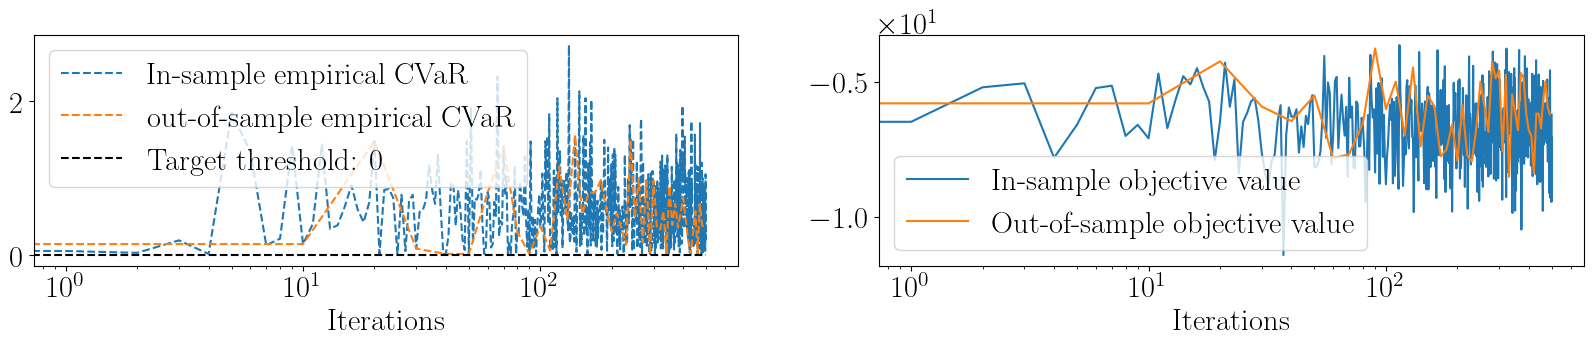

In [13]:
# training with linear NN - erratic balues
plot_iters(result.df,result.df_test, steps=num_iters, title="training")

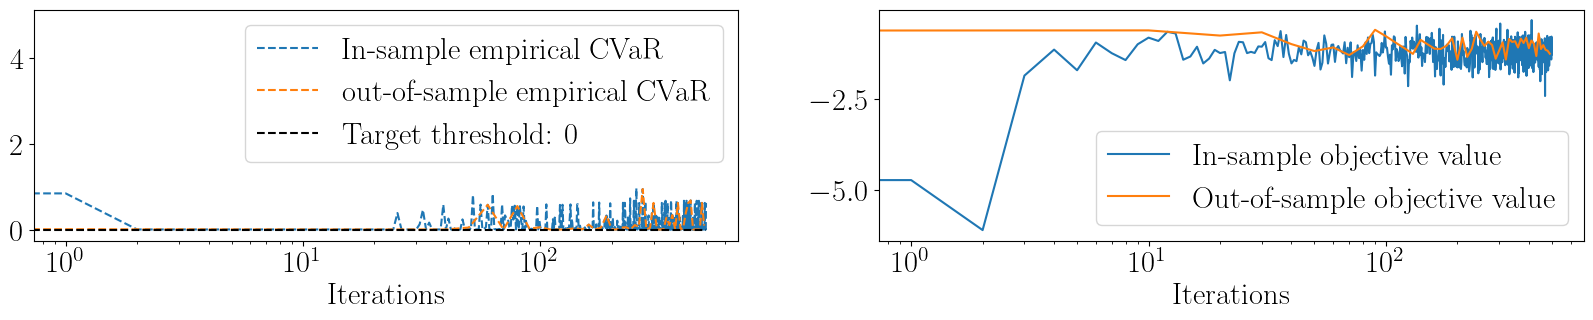

In [14]:
# training with covpred initialization - converges better but objective is much worse
plot_iters(result4.df,result4.df_test,steps=num_iters,title="training")

### plot tradeoff over radius

In [15]:
# Grid search epsilon
# mean variance set
eps_list = np.linspace(0.5, 2.5, 10)
result_grid = trainer.grid(rholst=eps_list, init_A=initn,
                    init_b=init_bvaln, seed=s,
                    init_alpha=0., test_percentage=test_p, quantiles = (0.3, 0.7))
dfgrid = result_grid.df
dfgrid.to_csv('mean_var_grid.csv')

# trained linear NN
result_grid2 = trainer.grid(rholst=eps_list,init_A=A_fin, init_b=b_fin, seed=s,init_alpha=0., test_percentage=test_p,quantiles = (0.3,0.7), contextual = True, linear = result._linear)
dfgrid2 = result_grid2.df
dfgrid2.to_csv('linear_trained_grid.csv')

# untrained linear NN
result_grid3 = trainer.grid(rholst=eps_list,init_A=A_fin2, init_b=b_fin2, seed=s,init_alpha=0., test_percentage=test_p,quantiles = (0.3,0.7), contextual = True, linear = result2._linear)
dfgrid3 = result_grid3.df
dfgrid3.to_csv('linear_untrained_grid.csv')

# covpred trained
result_grid5 = trainer.grid(rholst=eps_list,init_A=A_fin4, init_b=b_fin4, seed=s,init_alpha=0., test_percentage=test_p,quantiles = (0.3,0.7), contextual = True, covpred = True)
dfgrid5 = result_grid5.df
dfgrid5.to_csv('covpred_trained_grid.csv')


In [16]:
epslst =eps_list
prob_list = np.array([0.,0.01,0.05,0.1])
inds_standard = []
inds_reshaped = []
inds_untrained = []
inds_covpred_untrained = []
inds_covpred_trained = []
for i in prob_list:
    inds_standard.append(np.absolute(np.mean(np.vstack(dfgrid['Avg_prob_test']),axis = 1)-i).argmin())
    inds_reshaped.append(np.absolute(np.mean(np.vstack(dfgrid2['Avg_prob_test']),axis = 1)-i).argmin())
    inds_untrained.append(np.absolute(np.mean(np.vstack(dfgrid3['Avg_prob_test']),axis = 1)-i).argmin())
    inds_covpred_untrained.append(np.absolute(np.mean(np.vstack(dfgrid4['Avg_prob_test']),axis = 1)-i).argmin())
    inds_covpred_trained.append(np.absolute(np.mean(np.vstack(dfgrid5['Avg_prob_test']),axis = 1)-i).argmin())


### scenario approach

In [17]:
def calc_eval(x,p,k,u,t):
  val = 0
  vio = 0
  for i in range(u.shape[0]):
    val_cur = k@x + np.max([-p[0]*x[0] - p[1]*x[1],-p[0]*x[0] - p[1]*u[i][1], -p[0]*u[i][0] - p[1]*x[1], -p[0]*u[i][0]- p[1]*u[i][1]]) 
    val+= val_cur
    vio += (val_cur >= t)
  return val/u.shape[0], vio/u.shape[0]
context_evals = 0
context_probs = 0
# solve for each context and average
for context in range(num_context):
    u = lropt.UncertainParameter(n,
                            uncertainty_set=lropt.Scenario(
                                                        data=init_data[context][train_indices]))
    x_s = cp.Variable(n)
    t1 = cp.Variable()
    k1= init_k_data[context]
    p1 = init_p_data[context]
    objective = cp.Minimize(t1)
    constraints = [lropt.max_of_uncertain([-p1[0]*x_s[0] - p1[1]*x_s[1],
                                            -p1[0]*x_s[0] - p1[1]*u[1],
                                            -p1[0]*u[0] - p1[1]*x_s[1],
                                              -p1[0]*u[0]- p1[1]*u[1]])
                                              + k1@x_s <= t1]
    constraints += [x_s >= 0]

    prob_sc = lropt.RobustProblem(objective, constraints)
    prob_sc.solve()
    eval, prob_vio = calc_eval(x_s.value, init_p_data[context], init_k_data[context],init_data[context][test_indices],t1.value)
    context_evals += eval
    context_probs += prob_vio
print(context_evals/num_context, context_probs/num_context)

-5.955082048678074 0.23666666666666666


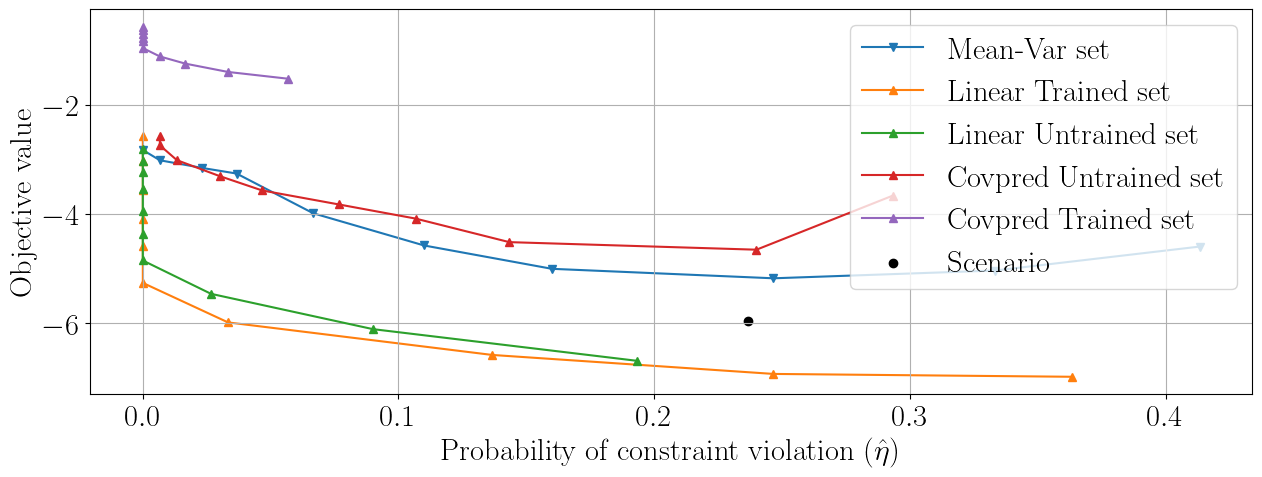

In [18]:
# indss = [5,9,13,18,19,20,21,22,23,25,26,27,28,29,30,31,32,33,34,35]
# dfgrid, dfgrid2 = results_grid4[(16,0.3)]
beg1, end1 = 0, 100
beg2, end2 = 0, 100
plt.figure(figsize=(15, 5))
plt.plot(np.mean(np.vstack(dfgrid['Avg_prob_test']), axis=1)[beg1:end1], np.mean(np.vstack(
    dfgrid['Test_val']), axis=1)[beg1:end1], color="tab:blue", label=r"Mean-Var set", marker="v", zorder=0)
plt.plot(np.mean(np.vstack(dfgrid2['Avg_prob_test']), axis=1)[beg2:end2], np.mean(np.vstack(
    dfgrid2['Test_val']), axis=1)[beg2:end2], color="tab:orange", label="Linear Trained set", marker="^", zorder=1)
plt.plot(np.mean(np.vstack(dfgrid3['Avg_prob_test']), axis=1)[beg2:end2], np.mean(np.vstack(
    dfgrid3['Test_val']), axis=1)[beg2:end2], color="tab:green", label="Linear Untrained set", marker="^", zorder=2)
plt.plot(np.mean(np.vstack(dfgrid4['Avg_prob_test']), axis=1)[beg2:end2], np.mean(np.vstack(
    dfgrid4['Test_val']), axis=1)[beg2:end2], color="tab:red", label="Covpred Untrained set", marker="^", zorder=3)
plt.plot(np.mean(np.vstack(dfgrid5['Avg_prob_test']), axis=1)[beg2:end2], np.mean(np.vstack(
    dfgrid5['Test_val']), axis=1)[beg2:end2], color="tab:purple", label="Covpred Trained set", marker="^", zorder=4)
plt.ylabel("Objective value")
plt.xlabel(r"Probability of constraint violation $(\hat{\eta})$")
# plt.ylim([-9, 0])
plt.grid()
plt.scatter(context_probs/num_context,context_evals/num_context, color = "black", label="Scenario")
plt.legend()
plt.savefig("news_objective_vs_violations.pdf", bbox_inches='tight')

It seems like for this seed, the reshaped set was able to get a slight improvement over the initialized set

In [19]:
K = 5
num_p = 50
offset = 5
x_min, x_max = np.min(train[:,0]) - offset, np.max(train[:,0]) + offset
y_min, y_max = np.min(train[:,1]) - offset, np.max(train[:,1]) + offset
X = np.linspace(x_min,x_max,num_p)
Y = np.linspace(y_min,y_max,num_p)
x,y = np.meshgrid(X,Y)

def gen_set(Amat,bvec,inds,K):
    fin_set = {}
    for ind in range(4):
        fin_set[ind] = {}
        for k_ind in range(K):
            fin_set[ind][k_ind] = np.zeros((num_p,num_p))
    for ind in range(4):
        for i in range(num_p):
            for j in range(num_p):
                u_vec = [x[i,j], y[i,j]]
                if K== 1:
                    fin_set[ind][0][i,j] = np.linalg.norm((1/eps_list[inds[ind]])*(Amat.T@np.linalg.inv(Amat@Amat.T))@(u_vec - bvec))
                else:
                    for k_ind in range(K):
                        fin_set[ind][k_ind][i,j] = np.linalg.norm((1/eps_list[inds[ind]])*(Amat[k_ind].T@np.linalg.inv(Amat[k_ind]@Amat[k_ind].T))@(u_vec - bvec[k_ind]))
    return fin_set
                
Amat = result._a_history[-1]*result.rho
bvec = result._b_history[-1]
fin_set = gen_set(Amat,bvec,inds_reshaped,K)
init_set = gen_set(initn,init_bvaln,inds_standard,K=1)
Amat2 = result2._a_history[-1]*result2.rho
bvec2 = result2._b_history[-1]
untrained_set = gen_set(Amat2,bvec2,inds_untrained,K)
Amat3 = result3._a_history[-1]*result3.rho
bvec3 = result3._b_history[-1]
covpred_set_untrained = gen_set(Amat3,bvec3,inds_covpred_untrained,K)
Amat4 = result4._a_history[-1]*result4.rho
bvec4 = result4._b_history[-1]
covpred_set_trained = gen_set(Amat4,bvec4,inds_covpred_trained,K)

In [ ]:
def plot_contours_line(x,y,set, prob_list, train, title, K=1):
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(16, 3.5), constrained_layout= True)
    ax_lst = [ax1, ax2, ax3, ax4]
    np.random.seed(0)
    newtrain = np.random.choice(num_reps,size=15,replace=False)
    cur_ind = 0
    for axis in ax_lst:
        axis.set_title(r'$\hat{\eta}$' + ' = {}'.format(prob_list[cur_ind]))
        axis.set_xlabel(r"$u_1$")
        axis.set_ylabel(r"$u_2$")
        axis.scatter(np.mean(train,axis= 0)[0], np.mean(train,axis= 0)[1],color = ["tab:green"])
        for k_ind in range(num_context):
            axis.scatter(init_data[k_ind][:,0][newtrain],init_data[k_ind][:,1][newtrain],edgecolor = "black")
        for k_ind in range(K):
            axis.contour(x,y,set[cur_ind][k_ind], [1], colors = ["red"],linewidths = [2])
        cur_ind +=1
    fig.suptitle(title +" set", fontsize = 30)
    plt.savefig(title+"_set"+ ".pdf", bbox_inches='tight')

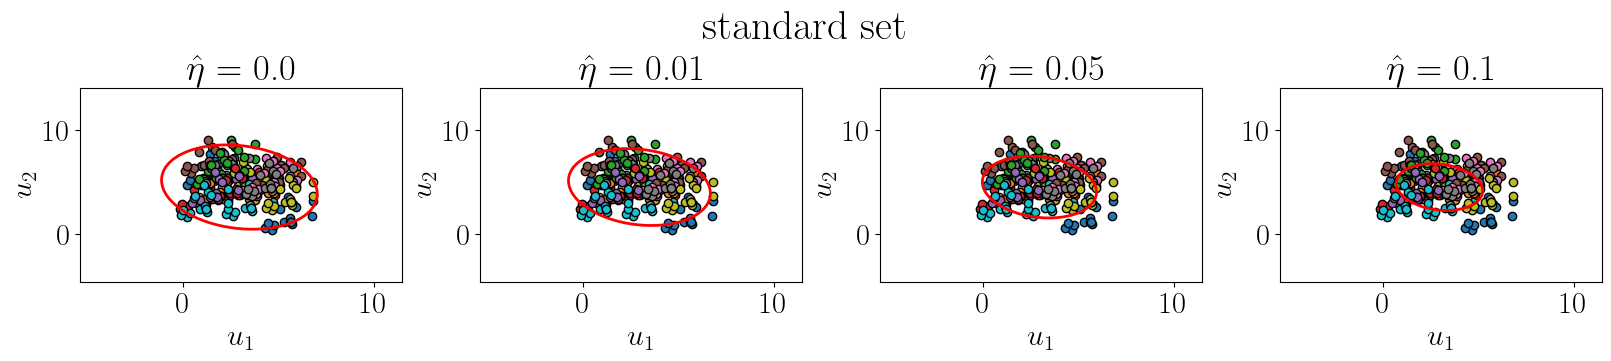

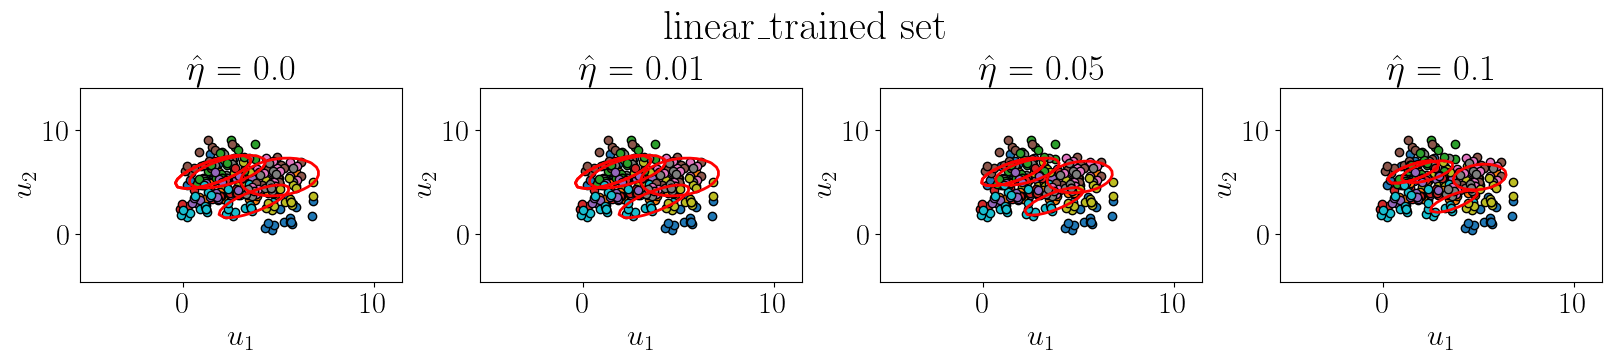

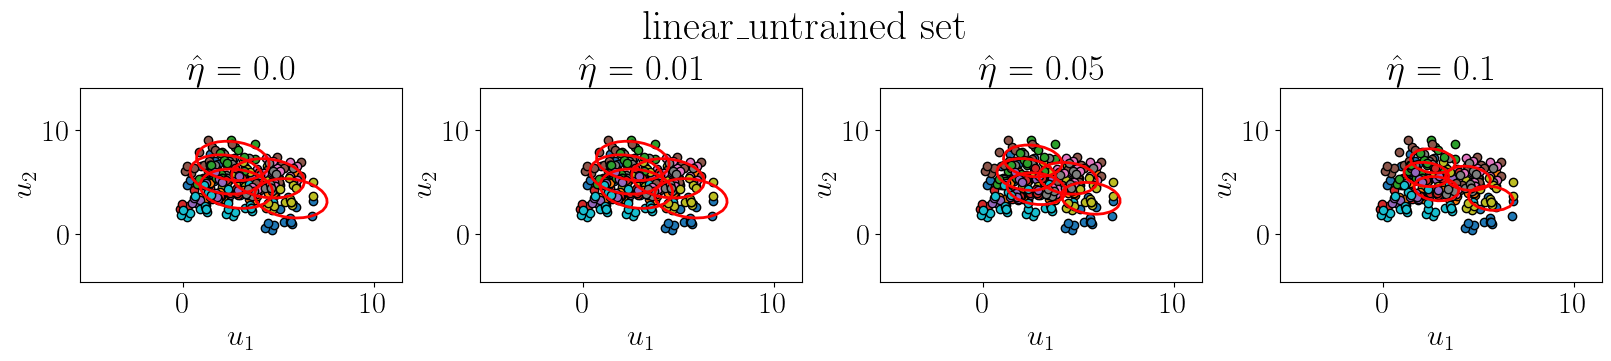

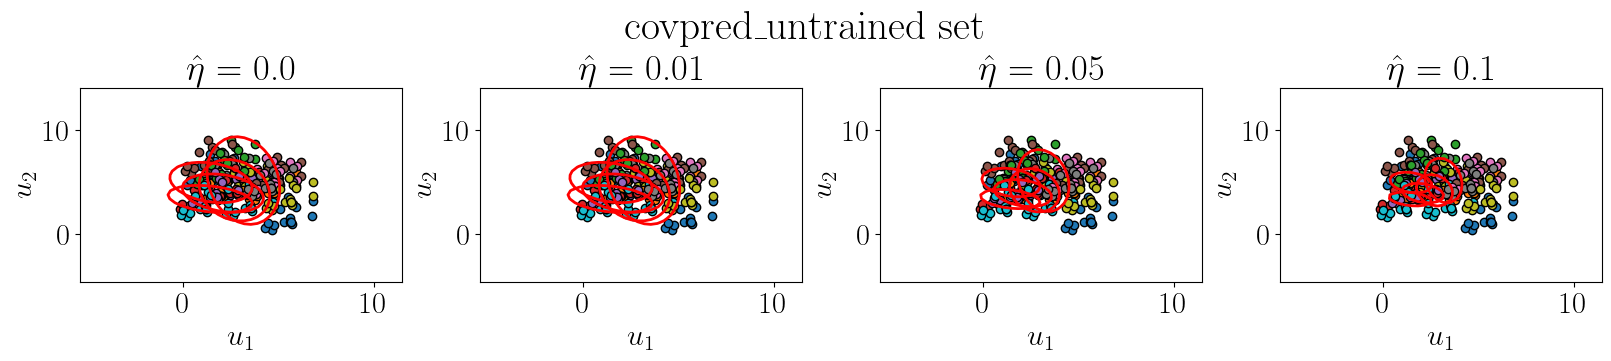

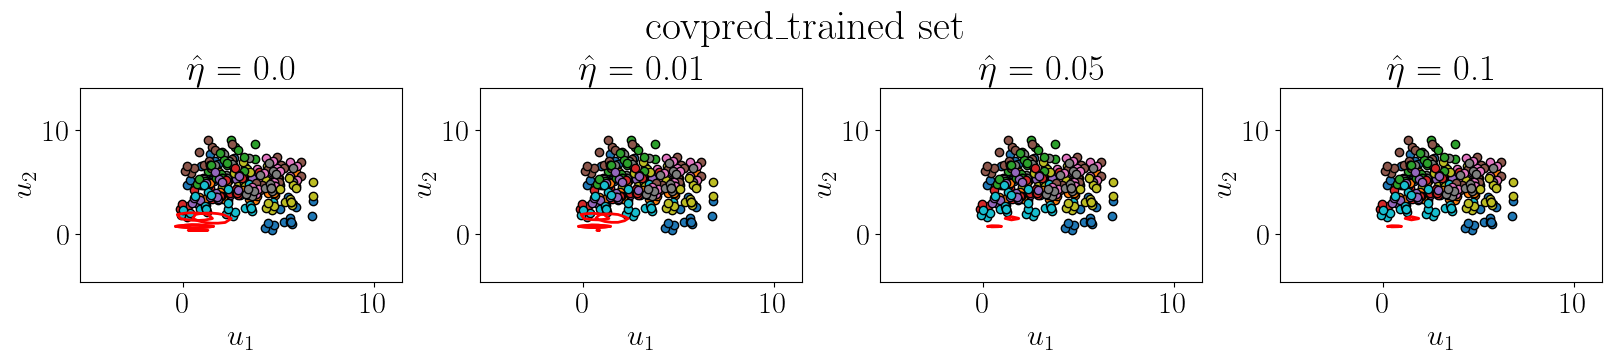

In [23]:
plot_contours_line(x,y,init_set,prob_list,train, "standard") 
plot_contours_line(x,y,fin_set, prob_list,train, "linear_trained", K=5)
plot_contours_line(x,y,untrained_set,prob_list,train, "linear_untrained", K=5)
plot_contours_line(x,y,covpred_set_untrained, prob_list,train, "covpred_untrained", K=5)
plot_contours_line(x,y,covpred_set_trained, prob_list,train, "covpred_trained", K=5)